In [43]:
#Load the json to access the Kaggle's API
from google.colab import files
import os
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"memovdg","key":"447e8ce1038625b724217bc6fe5103df"}'}

In [44]:
#Creating the directory to save the data
! mkdir ~/.kaggle
#Copy the access
! cp kaggle.json ~/.kaggle/
#Give it permission
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list //List the data sets

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [45]:
#Download data set and unzip 
! kaggle competitions download -c ieee-fraud-detection
! unzip train_transaction.csv.zip
! unzip train_identity.csv.zip
! unzip test_transaction.csv.zip
! unzip test_identity.csv.zip
! unzip sample_submission.csv.zip

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_transaction.csv   
Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_identity.csv      
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_transaction.csv    
Archive:  test_identity.csv.zip
repl

In [46]:
import pandas as pd
import numpy as np
#read the data
test_transaction = pd.read_csv("test_transaction.csv")
train_transaction = pd.read_csv("train_transaction.csv")

train_identity = pd.read_csv("train_identity.csv")
test_identity = pd.read_csv("train_identity.csv")

test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [47]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df




#Reduce the memory usage for the dara set
test_transaction = reduce_mem_usage(test_transaction)
train_transaction = reduce_mem_usage(train_transaction)

train_identity = reduce_mem_usage(train_identity)
test_identity = reduce_mem_usage(train_identity)



Mem. usage decreased to 1822.77 Mb (0.4% reduction)
Mem. usage decreased to 2111.33 Mb (0.6% reduction)
Mem. usage decreased to 161.39 Mb (0.3% reduction)
Mem. usage decreased to 161.39 Mb (0.0% reduction)


In [48]:
#Merge the data into train and test
train = pd.merge(train_transaction, train_identity, on="TransactionID", how='left')
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

train.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#Clean memory
del train_transaction
del train_identity
del test_transaction
del test_identity

train.shape
test.shape

(506691, 433)

Text(0.5, 1.0, 'Distribution of transaction dates')

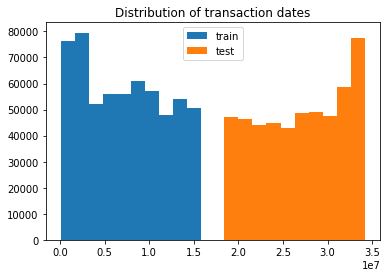

In [50]:
#Check the distribution of transaction dates
import matplotlib.pyplot as plt
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of transaction dates')

In [51]:
train.columns

#Clear the data, removing the NaN
null_percent = train.isnull().sum()/train.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 30].index)
cols_to_drop

array(['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141', 'V142',
       'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150',
       'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158',
       'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174',
       'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182',
       'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190',
       'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198',
       'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206',
       'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214',
       'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222',
 

In [0]:
#Clean the data
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [53]:
null_percent = test.isnull().sum()/train.shape[0]*100

null_cols = null_percent[null_percent > 0].keys()

null_cols

Index(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=153)

In [0]:
#Fill with nulls
for i in null_cols:
    train[i] = train[i].replace(np.nan, train[i].mode()[0])
    test[i] = test[i].replace(np.nan, train[i].mode()[0])

In [55]:
x = train.drop('isFraud', axis=1)
y = train['isFraud']

#Separating the data into categorical or numerical
cat_data = x.select_dtypes(include='object')
num_data = x.select_dtypes(exclude='object')

cat_cols = cat_data.columns.values
num_cols = num_data.columns.values

print('Categorical columns: ', cat_cols )
print('Numerical columns: ', num_cols)

Categorical columns:  ['ProductCD' 'card4' 'card6' 'P_emaildomain' 'M6']
Numerical columns:  ['TransactionID' 'TransactionDT' 'TransactionAmt' 'card1' 'card2' 'card3'
 'card5' 'addr1' 'addr2' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9'
 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D4' 'D10' 'D15' 'V12' 'V13' 'V14'
 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24' 'V25' 'V26'
 'V27' 'V28' 'V29' 'V30' 'V31' 'V32' 'V33' 'V34' 'V35' 'V36' 'V37' 'V38'
 'V39' 'V40' 'V41' 'V42' 'V43' 'V44' 'V45' 'V46' 'V47' 'V48' 'V49' 'V50'
 'V51' 'V52' 'V53' 'V54' 'V55' 'V56' 'V57' 'V58' 'V59' 'V60' 'V61' 'V62'
 'V63' 'V64' 'V65' 'V66' 'V67' 'V68' 'V69' 'V70' 'V71' 'V72' 'V73' 'V74'
 'V75' 'V76' 'V77' 'V78' 'V79' 'V80' 'V81' 'V82' 'V83' 'V84' 'V85' 'V86'
 'V87' 'V88' 'V89' 'V90' 'V91' 'V92' 'V93' 'V94' 'V95' 'V96' 'V97' 'V98'
 'V99' 'V100' 'V101' 'V102' 'V103' 'V104' 'V105' 'V106' 'V107' 'V108'
 'V109' 'V110' 'V111' 'V112' 'V113' 'V114' 'V115' 'V116' 'V117' 'V118'
 'V119' 'V120' 'V121' 'V122' 'V123' 'V12

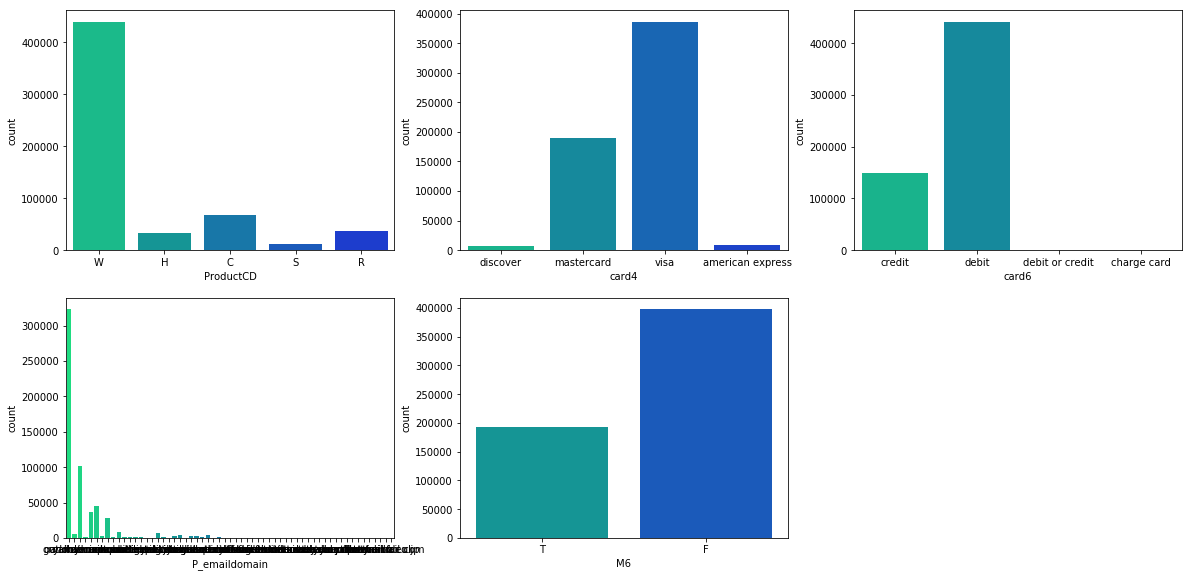

In [56]:
import seaborn as sns

#Plotting the categorical data
fig = plt.figure(figsize =(20,15))
j=1
for i in cat_cols:
  plt.subplot(3,3,j)
  sns.countplot(x=x[i], palette='winter_r')
  j+=1

plt.show()

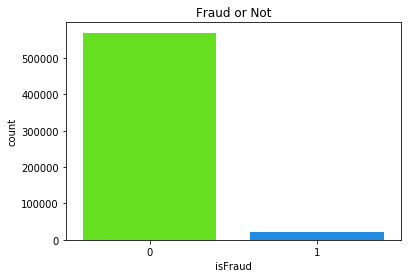

In [57]:
sns.countplot(x=y, palette='gist_rainbow')
plt.title('Fraud or Not')
plt.show()

In [60]:
#Pre processing the data 
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,M6,V12,V13,V14,V15,V16,V17,V18,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,0.977038,W,13926,321.0,150.0,discover,142.0,credit,315.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,13.0,0.0,T,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,0.909015,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,T,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,0.966273,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,315.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,0.953860,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,94.0,84.0,111.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,0.953860,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,F,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
y_train = train['isFraud']
train = pd.get_dummies(train)
x_train = train.drop('isFraud', axis=1)
x_train = x_train.fillna(0)

In [64]:

q = 0
scaler = MinMaxScaler()
for col in x_train.columns:
    a = np.array(x_train[col])
    a = a.reshape(-1,1)
    x_train[col] = scaler.fit_transform(a)
    if q >= 100:
        break
    else:
        q+=1
        continue
x_train.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,...,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,M6_F,M6_T
0,0.000000,0.000000e+00,0.756064,0.743044,0.442,0.381679,0.306569,0.488636,0.836957,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000627,0.0,0.000343,0.0007,0.021875,0.123108,0.01484,0.086279,0.333333,0.166667,1.0,0.0,0.0,0.0,0.0,0.142857,0.066667,0.0,0.0,0.076923,0.076923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.000002,6.359409e-08,0.691209,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.123108,0.00000,0.086279,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.142857,0.066667,0.0,0.0,0.076923,0.076923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.000003,4.387992e-06,0.745801,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.123108,0.00000,0.413721,0.333333,0.166667,1.0,0.0,0.0,0.0,0.0,0.142857,0.066667,0.0,0.0,0.076923,0.076923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000005,6.295815e-06,0.733966,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,0.000427,0.000879,0.0,0.0,0.0,0.001775,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.008568,0.0007,0.175000,0.217962,0.09589,0.201663,0.333333,0.166667,1.0,0.0,0.0,0.0,0.0,0.142857,0.066667,0.0,0.0,0.076923,0.076923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0.000007,6.740974e-06,0.733966,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,0.123108,0.00000,0.086279,0.333333,0.166667,1.0,0.0,0.0,0.0,0.0,0.142857,0.066667,0.0,0.0,0.076923,0.076923,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
vectorizer = CountVectorizer()

joblib.dump(x,'dataset.joblib')
joblib.dump(y_train, 'datasety.joblib')

x_final_train = joblib.load('dataset.joblib')
y_final_train = joblib.load('datasety.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [69]:
#Training the data using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver = 'liblinear', random_state=42)
lr.fit(x_train, y_train[:np.shape(x_train)[0]])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
score = cross_val_score(lr, x_train, y_train[:np.shape(x_train)[0]], cv=3,verbose=3)

score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] .................................... , score=0.964, total= 1.6min
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


[CV] .................................... , score=0.964, total= 1.2min
[CV]  ................................................................
[CV] .................................... , score=0.964, total= 1.7min


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.5min finished


0.9640752522173833